In [1]:
import torch
from transformer_lens import HookedTransformer
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM

features = 1
autoencoder_path = "/mnt/ssd-cluster/longrun2408/tied_residual_l2_r6/_31/learned_dicts.pt"
autoencoder_index = 5
layer = 2
dataset_name = "NeelNanda/pile-10k"
device = "cuda:0"
model_name = "EleutherAI/pythia-70m-deduped"
setting= "residual"
max_seq_length=30
# input_setting = "input_only"
input_setting = "both"

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
else:
    raise NotImplementedError

model_id = "Elriggs/pythia-70m-deduped"
ae_download_location = hf_hub_download(repo_id=model_id, filename=f"tied_residual_l{layer}_r6/_63/learned_dicts.pt")
all_autoencoders = torch.load(ae_download_location)
num_l1s = len(all_autoencoders)
all_l1s = [hyperparams["l1_alpha"] for autoencoder, hyperparams in all_autoencoders]
print(all_l1s)
auto_num = 5
autoencoder, hyperparams = all_autoencoders[auto_num]
autoencoder.to_device(device)
cache_name = f"gpt_neox.layers.{layer}"

# model = HookedTransformer.from_pretrained_no_processing(model_name, device = device)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]


In [2]:
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=None) # num_datapoints grabs all of them if None

Found cached dataset parquet (/root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5794dc4c32dc1e47.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-225a77b9775e981c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-db79252a408aab7b.arrow


100%|██████████| 310/310 [00:13<00:00, 22.73it/s]
/root/sparse_coding/utils_interp.py:301: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Dataset

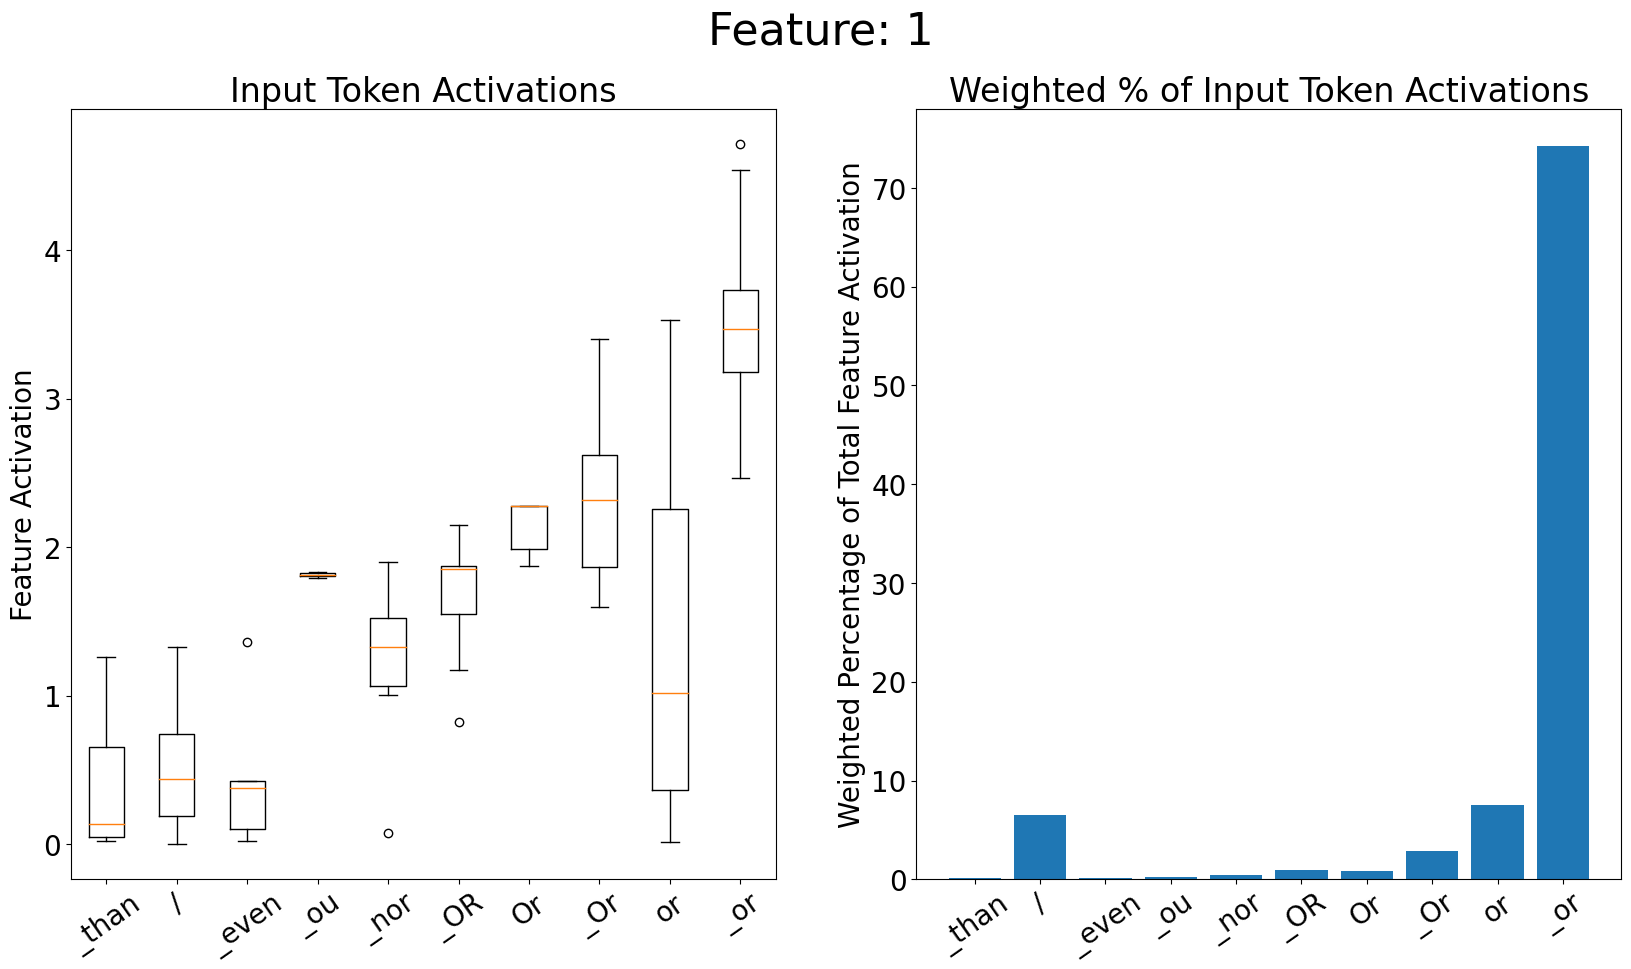

In [3]:
from utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

features = [1,2,3,4,5,6,7,8,9,10]

for feature in features:
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences")
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    combine_images(feature, setting=input_setting)

In [5]:
torch.stack(full_token_list)

tensor([[ 3404,   776,  1682,    13,   359, 41509,  9361,  1046,  1388,   281,
           755, 14186,   285,   564,   281,   789,   390,  2143,    15,  4129,
           627,   403,  4067, 26911,   387,   789,    13,   352,   434,   776],
        [  510, 35247,  6480,    14, 15505,   390, 25115,  9606,   407, 22085,
          8811,   327,  7814,    13,   672,   253,  1375,   457,    84,  8945,
            14, 26454,  6757,  2197,   562,   247,  3221, 10028,  9734,   273],
        [18681,    15, 29580, 16732,   313,    42,    14, 28889,    10, 47414,
           521,  3786,  2918,  1273,  1659,  1899,    13,  2556,   281,   271,
         17535,   382,    16,  1394,    40,   729,  8461,  4439,  8330,    13],
        [ 6812, 20227,   367,  6595,  1257,   187,   187,  6812, 20227,   367,
          6595,  1257, 50276,   261,   247, 35085,   285, 39738,   273,  5685,
           285,  4782, 47166,    15,   754,  8899,   598,   275,  4255,    14]])

In [7]:
# Run example text through model
text = "I like to eat pizza."
tokens = tokenizer(text, return_tensors="pt").input_ids.to(device)
# outputs = model(tokens)
# outputs.logits

device = model.device
def less_than_rank_1_ablate(value, hook):
    # Only ablate the feature direction up to the negative bias
    # ie Only subtract when it activates above that negative bias.

    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    act = autoencoder.encode(int_val)
    dictionary_for_this_autoencoder = autoencoder.get_learned_dict()
    feature_direction = torch.outer(act[:, feature].squeeze(), dictionary_for_this_autoencoder[feature].squeeze())
    batch, seq_len, hidden_size = value.shape
    feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
    value -= feature_direction
    return value

# with Trace(model, cache_name, edit_output=less_than_rank_1_ablate) as ret:
#     _ = model(batch).logits
#     representation = ret.output
#     # check if instance tuple
#     if(isinstance(representation, tuple)):
#         representation = representation[0]


batch = tokens
original_logits = model(batch).logits.log_softmax(dim=-1)
# with Trace(model, cache_name, edit_output=less_than_rank_1_ablate) as ret:
with Trace(model, cache_name, edit_output=less_than_rank_1_ablate) as ret:
    ablated_logits = model(batch).logits

RuntimeError: Tensor type unknown to einops <class 'tuple'>

In [ ]:

# def ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature, batch_size=32):

device = model.cfg.device
def less_than_rank_1_ablate(value, hook):
    # Only ablate the feature direction up to the negative bias
    # ie Only subtract when it activates above that negative bias.
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    act = autoencoder.encode(int_val)
    dictionary_for_this_autoencoder = autoencoder.get_learned_dict()
    feature_direction = torch.outer(act[:, feature].squeeze(), dictionary_for_this_autoencoder[feature].squeeze())
    batch, seq_len, hidden_size = value.shape
    feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
    value -= feature_direction
    return value

# tokens_batched = full_tokens_list
tokens_batched = torch.stack(full_token_list)
logit_diffs = torch.zeros((tokens_batched.shape[0], tokens_batched.shape[1]-1))

with torch.no_grad(), dataset.formatted_as("pt"):
    original_logits = model(tokens_batched.to(device)).log_softmax(dim=-1)
    ablated_logits = model.run_with_hooks(tokens_batched.to(device), fwd_hooks=[(cache_name, less_than_rank_1_ablate)]).log_softmax(dim=-1)
    diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
    gather_tokens = rearrange(tokens_batched[:,1:].to(device), "b s -> b s 1")
    gathered = diff_logits[:, :-1].gather(-1,gather_tokens)
    # append all 0's to the beggining of gathered
    gathered = torch.cat([torch.zeros((gathered.shape[0],1,1)).to(device), gathered], dim=1)
    logit_diffs = rearrange(gathered, "b s n -> (b s n)").cpu()

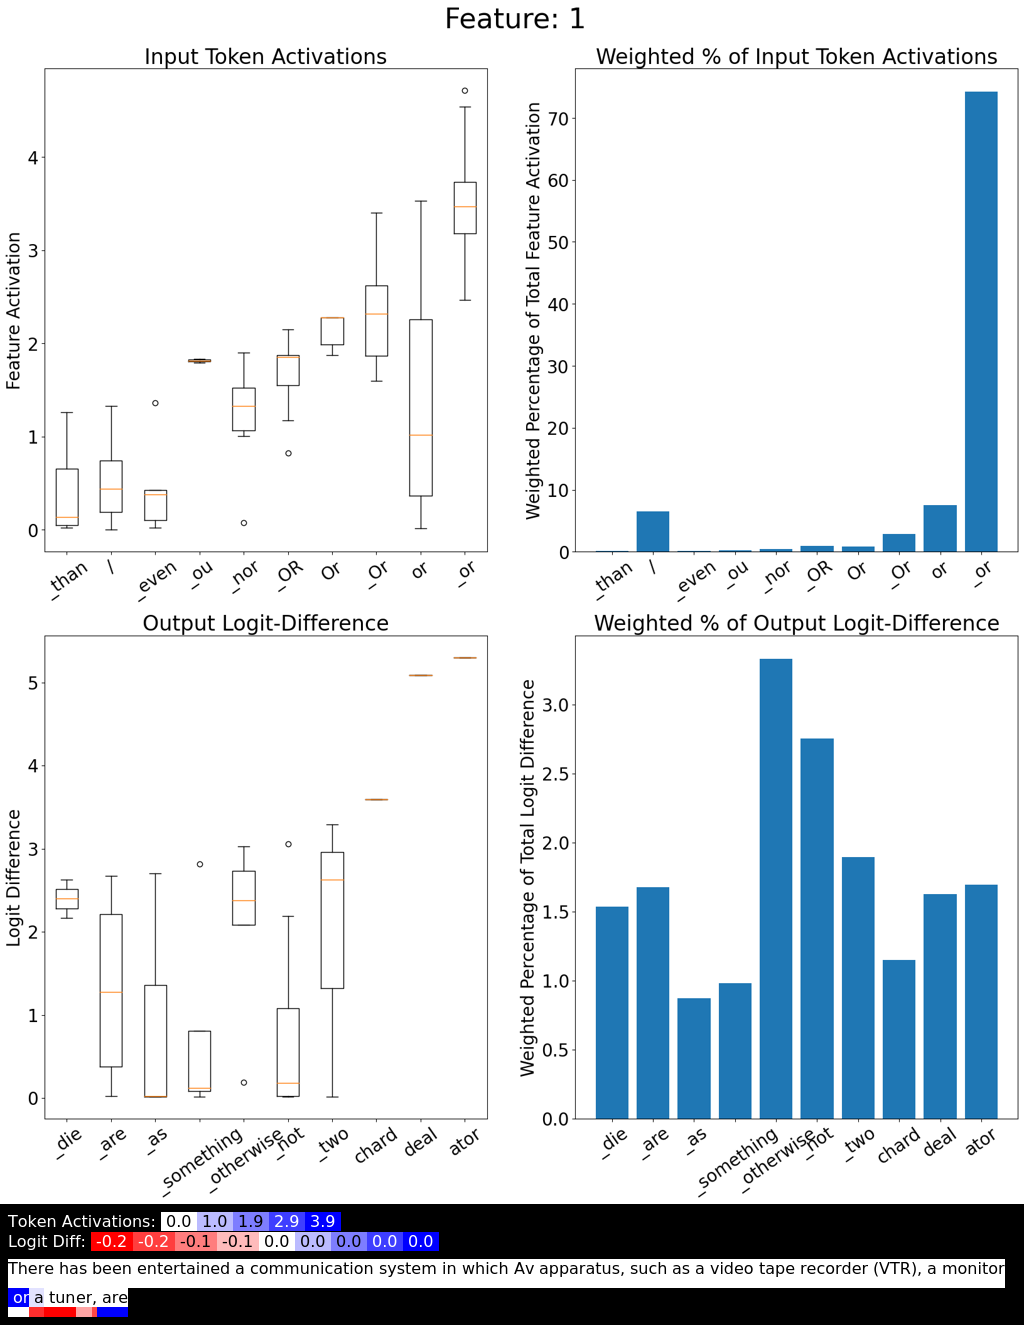

In [ ]:
def make_colorbar(min_value, max_value, white = 255, red_blue_ness = 250, positive_threshold = 0.01, negative_threshold = 0.01):
    # Add color bar
    colorbar = ""
    num_colors = 4
    if(min_value < -negative_threshold):
        for i in range(num_colors, 0, -1):
            ratio = i / (num_colors)
            value = round((min_value*ratio),1)
            text_color = "255,255,255" if ratio > 0.5 else "0,0,0"
            colorbar += f'<span style="background-color:rgba(255, {int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},1); color:rgb({text_color})">&nbsp{value}&nbsp</span>'
    # Do zero
    colorbar += f'<span style="background-color:rgba({white},{white},{white},1);color:rgb(0,0,0)">&nbsp0.0&nbsp</span>'
    # Do positive
    if(max_value > positive_threshold):
        for i in range(1, num_colors+1):
            ratio = i / (num_colors)
            value = round((max_value*ratio),1)
            text_color = "255,255,255" if ratio > 0.5 else "0,0,0"
            colorbar += f'<span style="background-color:rgba({int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},255,1);color:rgb({text_color})">&nbsp{value}&nbsp</span>'
    return colorbar

def value_to_color(activation, max_value, min_value, white = 255, red_blue_ness = 250, positive_threshold = 0.01, negative_threshold = 0.01):
    if activation > positive_threshold:
        ratio = activation/max_value
        text_color = "0,0,0" if ratio <= 0.5 else "255,255,255"  
        background_color = f'rgba({int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},255,1)'
    elif activation < -negative_threshold:
        ratio = activation/min_value
        text_color = "0,0,0" if ratio <= 0.5 else "255,255,255"  
        background_color = f'rgba(255, {int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},1)'
    else:
        text_color = "0,0,0"
        background_color = f'rgba({white},{white},{white},1)'
    return text_color, background_color

def convert_token_array_to_list(array):
    if isinstance(array, torch.Tensor):
        if array.dim() == 1:
            array = [array.tolist()]
        elif array.dim()==2:
            array = array.tolist()
        else: 
            raise NotImplementedError("tokens must be 1 or 2 dimensional")
    elif isinstance(array, list):
        # ensure it's a list of lists
        if isinstance(array[0], int):
            array = [array]
    return array

def tokens_and_activations_to_html(toks, activations, tokenizer, logit_diffs=None):
    # text_spacing = "0.07em"
    text_spacing = "0.00em"
    toks = convert_token_array_to_list(toks)
    activations = convert_token_array_to_list(activations)
    # toks = [[tokenizer.decode(t).replace('Ġ', '&nbsp').replace('\n', '↵') for t in tok] for tok in toks]
    toks = [[tokenizer.decode(t).replace('Ġ', '&nbsp').replace('\n', '\\n') for t in tok] for tok in toks]
    highlighted_text = []
    # Make background black
    # highlighted_text.append('<body style="background-color:black; color: white;">')
    highlighted_text.append("""
<body style="background-color: black; color: white;">
""")
    max_value = max([max(activ) for activ in activations])
    min_value = min([min(activ) for activ in activations])
    if(logit_diffs):
        logit_max_value = max([max(activ) for activ in logit_diffs])
        logit_min_value = min([min(activ) for activ in logit_diffs])

    # Add color bar
    highlighted_text.append("Token Activations: " + make_colorbar(min_value, max_value))
    if(logit_diffs):
        highlighted_text.append('<div style="margin-top: 0.1em;"></div>')
        highlighted_text.append("Logit Diff: " + make_colorbar(logit_min_value, logit_max_value))
    
    highlighted_text.append('<div style="margin-top: 0.5em;"></div>')
    for seq_ind, (act, tok) in enumerate(zip(activations, toks)):
        for act_ind, (a, t) in enumerate(zip(act, tok)):
            if(logit_diffs):
                highlighted_text.append('<div style="display: inline-block;">')
            text_color, background_color = value_to_color(a, max_value, min_value)
            highlighted_text.append(f'<span style="background-color:{background_color};margin-right: {text_spacing}; color:rgb({text_color})">{t.replace(" ", "&nbsp")}</span>')
            if(logit_diffs):
                logit_diffs_act = logit_diffs[seq_ind][act_ind]
                _, logit_background_color = value_to_color(logit_diffs_act, logit_max_value, logit_min_value)
                highlighted_text.append(f'<div style="display: block; margin-right: {text_spacing}; height: 10px; background-color:{logit_background_color}; text-align: center;"></div></div>')
        highlighted_text.append('<div style="margin-top: 0.2em;"></div>')
        # highlighted_text.append('<br><br>')
    # highlighted_text.append('</body>')
    highlighted_text = ''.join(highlighted_text)
    return highlighted_text

def display_tokens(tokens, activations, tokenizer, logit_diffs=None):
    return display(HTML(tokens_and_activations_to_html(tokens, activations, tokenizer, logit_diffs)))

def save_token_display(tokens, activations, tokenizer, path, logit_diffs=None):
    html = tokens_and_activations_to_html(tokens, activations, tokenizer, logit_diffs)
    imgkit.from_string(html, path)
    # print(f"Saved to {path}")
    return
save_token_display(full_token_list_ablated, full_activations, model.tokenizer, path =f"{save_path}uniform_black_{feature}.png", logit_diffs = full_activations_ablated)
# display_tokens(full_token_list_ablated, full_activations, model.tokenizer, logit_diffs = full_activations_ablated)

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Load an existing image
image = Image.open(f"concatenated_image.png")

# Create a drawing object
draw = ImageDraw.Draw(image)

# Define the position for the text to be placed (this example puts it at the top-center)
text = "Feature {feature}"
text_position = (image.width // 2, 10)

# You can use a truetype or opentype font file if you want to customize
# Otherwise, PIL provides a basic built-in font
try:
    font = ImageFont.truetype("arial.ttf", size=30)
except IOError:
    font = ImageFont.load_default()

# Calculate text size and position to center-align the text
text_width, text_height = draw.textsize(text, font=font)
text_position = ((image.width - text_width) // 2, 100)

# Add the text to image
draw.text(text_position, text, font=font, fill="white")

# Save or show the image
image.save("image_with_title.png")
image.show()


In [ ]:
font.font.getsize(text)

In [ ]:
text_position, text, font

In [ ]:
from IPython.core.display import display, HTML

# The initial HTML and CSS to set the background to black
initial_html = """
<!DOCTYPE html>
<html>
<head>
    <title>My Page</title>
</head>
<body style="background-color: blue;">
"""

# The HTML for the text spans that you'll append later
span_text = """
    <span style="color: white;">This is some text.</span>
    <span style="color: green;">This is some more text.</span>
"""

# Closing tags for the HTML
closing_html = """
</body>
</html>
"""

# Combine everything
full_html = initial_html + span_text + closing_html

# Display the HTML
display(HTML(full_html))

In [ ]:
model.cfg.device

In [ ]:
d_model = model.cfg.d_model
assert (d_model == autoencoder.encoder.shape[-1]), f"Model and autoencoder must have same hidden size. Model: {d_model}, Autoencoder: {autoencoder.encoder.shape[-1]}"

In [ ]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
def get_dictionary_activations(model, dataset, cache_name, autoencoder, batch_size=32):
    num_features, d_model = autoencoder.encoder.shape
    datapoints = dataset.num_rows
    dictionary_activations = torch.zeros((datapoints*max_seq_length, num_features))
    token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            batched_dictionary_activations = autoencoder.encode(batched_neuron_activations)
            dictionary_activations[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length,:] = batched_dictionary_activations.cpu()
    return dictionary_activations, token_list

print("Getting dictionary activations")
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, autoencoder, batch_size=32)

In [ ]:

def ablate_feature_direction(model, dataset, cache_name, autoencoder, feature, batch_size=32):
    def less_than_rank_1_ablate(value, hook):
        # Only ablate the feature direction up to the negative bias
        # ie Only subtract when it activates above that negative bias.

        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')
        # Run through the autoencoder
        act = autoencoder.encode(int_val)
        dictionary_for_this_autoencoder = autoencoder.get_learned_dict()
        feature_direction = torch.outer(act[:, feature].squeeze(), dictionary_for_this_autoencoder[feature].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    datapoints = dataset.num_rows
    logit_diffs = torch.zeros((datapoints*max_seq_length))
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            original_logits = model(batch.to(device)).log_softmax(dim=-1)
            ablated_logits = model.run_with_hooks(batch.to(device), fwd_hooks=[(cache_name, less_than_rank_1_ablate)]).log_softmax(dim=-1)
            diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
            gather_tokens = rearrange(batch[:,1:].to(device), "b s -> b s 1")
            gathered = diff_logits[:, :-1].gather(-1,gather_tokens)
            # append all 0's to the beggining of gathered
            gathered = torch.cat([torch.zeros((gathered.shape[0],1,1)).to(device), gathered], dim=1)
            diff = rearrange(gathered, "b s n -> (b s n)")
            # Add one to the first position of logit diff, so we're always skipping over the first token (since it's not predicted)
            logit_diffs[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = diff.cpu()
    return logit_diffs
feature = 1
logit_diffs = ablate_feature_direction(model, dataset, cache_name, autoencoder, feature = feature, batch_size=32)

In [ ]:
# # from interp_utils import *
# if isinstance(features, int):
#     features = [features]
# for feature in features:
#     text_list, full_text, token_list, full_token_list = get_feature_datapoints(feature, dictionary_activations, model.tokenizer, max_seq_length, dataset, setting="uniform")
#     # text_list, full_text, token_list, full_token_list = get_feature_datapoints(feature, dictionary_activations, dataset, setting="max")
#     # visualize_text(full_text, feature, model, autoencoder, layer)
# l = visualize_text(text_list, feature, model, autoencoder, layer)

In [ ]:
from IPython.display import display, HTML
import imgkit

def make_colorbar(min_value, max_value, white = 245, red_blue_ness = 250, positive_threshold = 0.01, negative_threshold = 0.01):
    # Add color bar
    colorbar = ""
    num_colors = 4
    if(min_value < -negative_threshold):
        for i in range(num_colors, 0, -1):
            ratio = i / (num_colors)
            value = round((min_value*ratio),1)
            text_color = "255,255,255" if ratio > 0.5 else "0,0,0"
            colorbar += f'<span style="background-color:rgba(255, {int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},1); color:rgb({text_color})">&nbsp{value}&nbsp</span>'
    # Do zero
    colorbar += f'<span style="background-color:rgba({white},{white},{white},1);color:rgb(0,0,0)">&nbsp0.0&nbsp</span>'
    # Do positive
    if(max_value > positive_threshold):
        for i in range(1, num_colors+1):
            ratio = i / (num_colors)
            value = round((max_value*ratio),1)
            text_color = "255,255,255" if ratio > 0.5 else "0,0,0"
            colorbar += f'<span style="background-color:rgba({int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},255,1);color:rgb({text_color})">&nbsp{value}&nbsp</span>'
    return colorbar

def value_to_color(activation, max_value, min_value, white = 245, red_blue_ness = 250, positive_threshold = 0.01, negative_threshold = 0.01):
    if activation > positive_threshold:
        ratio = activation/max_value
        text_color = "0,0,0" if ratio <= 0.5 else "255,255,255"  
        background_color = f'rgba({int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},255,1)'
    elif activation < -negative_threshold:
        ratio = activation/min_value
        text_color = "0,0,0" if ratio <= 0.5 else "255,255,255"  
        background_color = f'rgba(255, {int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},1)'
    else:
        text_color = "0,0,0"
        background_color = f'rgba({white},{white},{white},1)'
    return text_color, background_color

def convert_token_array_to_list(array):
    if isinstance(array, torch.Tensor):
        if array.dim() == 1:
            array = [array.tolist()]
        elif array.dim()==2:
            array = array.tolist()
        else: 
            raise NotImplementedError("tokens must be 1 or 2 dimensional")
    elif isinstance(array, list):
        # ensure it's a list of lists
        if isinstance(array[0], int):
            array = [array]
    return array

def tokens_and_activations_to_html(toks, activations, tokenizer, logit_diffs=None):
    toks = convert_token_array_to_list(toks)
    activations = convert_token_array_to_list(activations)
    # toks = [[tokenizer.decode(t).replace('Ġ', '&nbsp').replace('\n', '↵') for t in tok] for tok in toks]
    toks = [[tokenizer.decode(t).replace('Ġ', '&nbsp').replace('\n', '\\n') for t in tok] for tok in toks]
    highlighted_text = []
    max_value = max([max(activ) for activ in activations])
    min_value = min([min(activ) for activ in activations])
    if(logit_diffs):
        logit_max_value = max([max(activ) for activ in logit_diffs])
        logit_min_value = min([min(activ) for activ in logit_diffs])

    # Add color bar
    highlighted_text.append("Token Activations: " + make_colorbar(min_value, max_value))
    if(logit_diffs):
        highlighted_text.append('<br><br>')
        highlighted_text.append("Logit Diff: " + make_colorbar(logit_min_value, logit_max_value))
        
    highlighted_text.append('<br><br>')
    for seq_ind, (act, tok) in enumerate(zip(activations, toks)):
        for act_ind, (a, t) in enumerate(zip(act, tok)):
            if(logit_diffs):
                highlighted_text.append('<div style="display: inline-block;">')
            text_color, background_color = value_to_color(a, max_value, min_value)
            highlighted_text.append(f'<span style="background-color:{background_color};color:rgb({text_color})">{t.replace(" ", "&nbsp")}</span>')
            if(logit_diffs):
                logit_diffs_act = logit_diffs[seq_ind][act_ind]
                _, logit_background_color = value_to_color(logit_diffs_act, logit_max_value, logit_min_value)
                highlighted_text.append(f'<div style="display: block; height: 10px; background-color:{logit_background_color}; text-align: center;"></div></div>')
        highlighted_text.append('<br><br>')
    highlighted_text = ''.join(highlighted_text)
    return highlighted_text

def display_tokens(tokens, activations, tokenizer, logit_diffs=None):
    return display(HTML(tokens_and_activations_to_html(tokens, activations, tokenizer, logit_diffs)))

def save_token_display(tokens, activations, tokenizer, path, logit_diffs=None):
    html = tokens_and_activations_to_html(tokens, activations, tokenizer, logit_diffs)
    imgkit.from_string(html, path)
    # print(f"Saved to {path}")
    return

In [ ]:
def get_feature_indices(feature_index, dictionary_activations, tokenizer, token_amount, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    return found_indices
def get_feature_datapoints(found_indices, best_feature_activations, tokenizer, token_amount, dataset):
    num_datapoints = dataset.num_rows
    datapoint_indices =[np.unravel_index(i, (num_datapoints, token_amount)) for i in found_indices]
    all_activations = best_feature_activations.reshape(num_datapoints, token_amount).tolist()
    full_activations = []
    partial_activations = []
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for i, (md, s_ind) in enumerate(datapoint_indices):
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        full_activations.append(all_activations[md])
        partial_activations.append(all_activations[md][:s_ind+1])
        text = tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, partial_activations, full_activations

uniform_indices = get_feature_indices(feature, dictionary_activations, model.tokenizer, max_seq_length, dataset, k=10, setting="uniform")
text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], model.tokenizer, max_seq_length, dataset)
display_tokens(token_list, partial_activations, model.tokenizer)

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

def get_token_statistics(feature, feature_activation, dataset, max_seq_length, save_location="", num_unique_tokens=10, setting="input", negative_threshold=-0.01):
    if(setting=="input"):
        nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
    else:
        nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
    nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

    # Unravel the indices to get the token IDs
    datapoint_indices = [np.unravel_index(i, (dataset.num_rows, max_seq_length)) for i in nonzero_indices]
    all_tokens = [dataset[int(md)]["input_ids"][int(s_ind)] for md, s_ind in datapoint_indices]

    # Find the max value for each unique token
    token_value_dict = defaultdict(int)
    for token, value in zip(all_tokens, nonzero_values):
        token_value_dict[token] = max(token_value_dict[token], value)
    # if(setting=="input"):
    sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
    # else:
    #     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
    # Take the top 10 (or fewer if there aren't 10)
    max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
    total_sums = nonzero_values.abs().sum()
    max_token_sums = []
    token_activations = []
    for max_token in max_tokens:
        # Find ind of max token
        max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
        # Grab the values for those indices
        max_token_values = nonzero_values[max_token_indices]
        max_token_sum = max_token_values.abs().sum()
        max_token_sums.append(max_token_sum)
        token_activations.append(max_token_values)


    if(setting=="input"):
        title_text = "Input Token Activations"
        save_name = "input"
        y_label = "Feature Activation"
    else:
        title_text = "Output Logit Difference"
        save_name = "logit_diff"
        y_label = "Logit Difference"

    # Plot a boxplot for each tensor in the list
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'{title_text}: feature={feature}')
    max_text = [model.tokenizer.decode([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
    # Set x-axis label
    ax.set_xlabel('Token')
    #rotate x labels
    plt.xticks(rotation=30)
    # Set y-axis label
    ax.set_ylabel(y_label)
    ax.boxplot(token_activations[::-1], labels=max_text[::-1])
    #Save it
    plt.savefig(f'{save_location}feature_{feature}_{save_name}_boxplot.png')

    #Bar graph of the percentage of total activations
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Weighted Percentage of {title_text}: feature={feature}')
    max_text = [model.tokenizer.decode([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
    # Set x-axis label
    ax.set_xlabel('Token')
    plt.xticks(rotation=30)

    # Set y-axis label
    ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
    ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])
    plt.savefig(f'{save_location}feature_{feature}_{save_name}_bar.png')
# get_token_statistics(feature, dictionary_activations[:, feature], dataset, max_seq_length, save_location = "features/", num_unique_tokens=10)
get_token_statistics(feature, logit_diffs, dataset, max_seq_length, save_location = "features/", setting="output", num_unique_tokens=10)

In [ ]:
(logit_diffs < -0.01).nonzero()[:, 0], feature_activation.nonzero()[:, 0]

In [ ]:
_, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, model.tokenizer, max_seq_length, dataset)
display_tokens(full_token_list_ablated, full_activations, model.tokenizer, logit_diffs = full_activations_ablated)

In [ ]:
tokens_and_activations_to_html(full_token_list_ablated, full_activations, model.tokenizer, logit_diffs = full_activations_ablated)

In [ ]:
display(HTML('<div style="display: inline-block;"><span style="background-color:rgba(245,245,245,1);color:rgb(0,0,0)">About</span><div style="display: block; height: 10px; background-color:rgba(245,245,245,1); text-align: center;"></div></div><div style="display: inline-block;"><span style="background-color:rgba(245,245,245,1);color:rgb(0,0,0)">\\n</span><div style="display: block; height: 10px; background-color:rgba(245,245,245,1); text-align: center;"></div></div><div style="display: inline-block;"><span style="background-color:rgba(245,245,245,1);color:rgb(0,0,0)">\\n</span><div style="display: block; height: 10px; background-color:rgba(245,245,245,1); text-align: center;"></div></div><div style="display: inline-block;"><span style="background-color:rgba(245,245,245,1);color:rgb(0,0,0)">Te</span><div style="display: block; height: 10px; background-color:rgba(245,245,245,1); text-align: center;"></div></div><div style="display: inline-block;"><span style="background-color:rgba(245,245,245,1);color:rgb(0,0,0)">ams</span><div style="display: block; height: 10px; background-color:rgba(245,245,245,1); text-align: center;"></div></div><div style="display: inline-block;"><span style="background-color:rgba(245,245,245,1);color:rgb(0,0,0)">&nbspare</span><div style="display: block; height: 10px; background-color:rgba(245,245,245,1); text-align: center;"></div></div>'))

In [ ]:
#def ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, batch_size=32):
all_changed_activations = []
for token_ind, token_l in enumerate(token_list):
# for token_ind, token_l in enumerate(full_token_list):
    seq_size = len(token_l)
    original_activation = partial_activations[token_ind][-1]
    # Run through the model for each seq length
    if(seq_size==1):
        continue # Size 1 sequences don't have any context to ablate
    # changed_activations = torch.zeros(seq_size).cpu() + original_activation
    changed_activations = torch.zeros(seq_size).cpu() 
    for i in range(seq_size-1):
        # ablated_tokens = token_l[:i+1] + token_l[i+1:]
        ablated_tokens = token_l
        ablated_tokens = torch.tensor(ablated_tokens).unsqueeze(0)
        with torch.no_grad():
            _, cache = model.run_with_cache(ablated_tokens.to(device))
            neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            dictionary_activations = autoencoder.encode(neuron_activations)

            changed_activations[i] += dictionary_activations[-1,feature].item()
    changed_activations -= original_activation
    all_changed_activations.append(changed_activations.tolist())

In [ ]:
display_tokens(token_list, all_changed_activations, model.tokenizer)

In [ ]:
all_changed_activations

In [ ]:
display_tokens(token_list, partial_activations, model.tokenizer)

In [ ]:
ablate_feature_direction_display(full_text, autoencoder, model, layer, features=feature)